In [1]:
import pandas as pd
import numpy as np
import spacy
import tensorflow as tf
from scipy import spatial
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from typing import Counter
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import joblib
from sklearn.metrics import f1_score, precision_score, average_precision_score, classification_report, precision_recall_curve

In [2]:
df_cleaned = pd.read_csv('cleaned_data_train.csv')
features = ["id","comment_text","toxic","severe_toxic","obscene","threat","insult","identity_hate"]
df_cleaned['comment_text']= df_cleaned['comment_text'].fillna('')

df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [3]:
# Load the tokenizer JSON
with open("tokenizer.json", "r") as f:
    tokenizer_json = f.read()
    tokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizer_json)

## Glove

In [4]:
# words dictionary
embeddings_dict = {}

def load_glove_embeddings():

    with open("glove.6B\glove.6B.50d.txt", 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict
embeddings_dict = load_glove_embeddings()

<>:6: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\g'
C:\Users\cavas\AppData\Local\Temp\ipykernel_11576\428815004.py:6: SyntaxWarning: invalid escape sequence '\g'
  with open("glove.6B\glove.6B.50d.txt", 'r', encoding="utf-8") as f:


In [5]:
def find_closest_embeddings(embedding):
    return sorted(embeddings_dict.keys(), key=lambda word: spatial.distance.euclidean(embeddings_dict[word], embedding))

find_closest_embeddings(embeddings_dict["ciao"])[:10]

['ciao',
 'bella',
 'bonjour',
 'macgruber',
 'pax',
 'tru',
 'lewitzky',
 'atlantica',
 'nuvo',
 'arris']

## Embedding Layer and Training Constant

In [6]:
# Training Constant
SEQUENCE_LENGTH = 100
VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
BATCH_SIZE = 128
EPOCHS = 10

In [7]:
word2idx = tokenizer.word_index
# creation of embedding matrix
num_words = min(VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < VOCAB_SIZE:
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

In [8]:
#Definition of embedding layer
embedding_layer = tf.keras.layers.Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=SEQUENCE_LENGTH,
  trainable=False
)

c:\Users\cavas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## CNN

In [9]:

def create_CNN():
        inputs = tf.keras.Input(shape=(SEQUENCE_LENGTH,))

        x = embedding_layer(inputs)
        x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
        x = tf.keras.layers.MaxPooling1D(3)(x)
        x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
        x = tf.keras.layers.MaxPooling1D(3)(x)
        x = tf.keras.layers.Conv1D(128, 3, activation='relu')(x)
        x = tf.keras.layers.GlobalMaxPooling1D()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)


        toxic_output = tf.keras.layers.Dense(1, activation='sigmoid', name='toxic')(x)  # Usa sigmoid per probabilità
        severe_toxic_output = tf.keras.layers.Dense(1, activation='sigmoid', name='severe_toxic')(x)
        obscene_output = tf.keras.layers.Dense(1, activation='sigmoid', name='obscene')(x)
        threat_output = tf.keras.layers.Dense(1, activation='sigmoid', name='threat')(x)
        insult_output = tf.keras.layers.Dense(1, activation='sigmoid', name='insult')(x)
        identity_hate_output = tf.keras.layers.Dense(1, activation='sigmoid', name='identity_hate')(x)

        outputs = [toxic_output, severe_toxic_output, obscene_output, threat_output, insult_output, identity_hate_output]

        model = tf.keras.Model(inputs, outputs)

        losses = {'toxic': tf.keras.losses.BinaryCrossentropy(),
                'severe_toxic': tf.keras.losses.BinaryCrossentropy(),
                'obscene': tf.keras.losses.BinaryCrossentropy(),
                'threat': tf.keras.losses.BinaryCrossentropy(),
                'insult': tf.keras.losses.BinaryCrossentropy(),
                'identity_hate': tf.keras.losses.BinaryCrossentropy(),
        }

        metrics = {
                'toxic': ['accuracy'],
                'severe_toxic': ['accuracy'],
                'obscene': ['accuracy'],
                'threat': ['accuracy'],
                'insult': ['accuracy'],
                'identity_hate': ['accuracy'],
        }

        model.compile(
        loss=losses,
        optimizer='rmsprop',
        metrics= metrics
        )
        return model

## MLP

In [10]:
inputs = tf.keras.Input(shape=(SEQUENCE_LENGTH,))

def create_MLP():
        x = embedding_layer(inputs)

        x = tf.keras.layers.GlobalAveragePooling1D()(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32, activation='relu')(x)

        toxic_output = tf.keras.layers.Dense(1, activation='sigmoid', name='toxic')(x)
        severe_toxic_output = tf.keras.layers.Dense(1, activation='sigmoid', name='severe_toxic')(x)
        obscene_output = tf.keras.layers.Dense(1, activation='sigmoid', name='obscene')(x)
        threat_output = tf.keras.layers.Dense(1, activation='sigmoid', name='threat')(x)
        insult_output = tf.keras.layers.Dense(1, activation='sigmoid', name='insult')(x)
        identity_hate_output = tf.keras.layers.Dense(1, activation='sigmoid', name='identity_hate')(x)
        

        outputs = [toxic_output, severe_toxic_output, obscene_output, threat_output, insult_output, identity_hate_output]

        model = tf.keras.Model(inputs, outputs)

        losses = {'toxic': tf.keras.losses.BinaryCrossentropy(),
                'severe_toxic': tf.keras.losses.BinaryCrossentropy(),
                'obscene': tf.keras.losses.BinaryCrossentropy(),
                'threat': tf.keras.losses.BinaryCrossentropy(),
                'insult': tf.keras.losses.BinaryCrossentropy(),
                'identity_hate': tf.keras.losses.BinaryCrossentropy(),
        }
        losses = {name: tf.keras.losses.BinaryCrossentropy(from_logits=False) for name in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']}

        metrics = {
                'toxic': ['accuracy'],
                'severe_toxic': ['accuracy'],
                'obscene': ['accuracy'],
                'threat': ['accuracy'],
                'insult': ['accuracy'],
                'identity_hate': ['accuracy'],
        }

        model.compile(
        loss=losses,
        optimizer='adam',
        metrics= metrics
        )
        return model

## SVM

In [11]:
ngram = (1,1)
vectorizer = TfidfVectorizer(max_features=VOCAB_SIZE,ngram_range=ngram)
X = vectorizer.fit_transform(df_cleaned['comment_text'])

def create_SVM():
    model = make_pipeline( OneVsRestClassifier(SVC(kernel='sigmoid')))
    return model



In [ ]:
#SVM training test with few data and saving
label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

X = vectorizer.transform(df_cleaned['comment_text'].astype(str))
y = df_cleaned[label_cols]

# Create a 'label sum' for stratification
label_sums = y.sum(axis=1)

X_train, X_dev, y_train_split, y_dev = train_test_split(
    X, y, test_size=0.8, random_state=42, stratify=label_sums
)

model = create_SVM()

model.fit(X_train,y_train_split)

joblib.dump(model, './models/svm.pkl') 

['./models/svm.pkl']

In [13]:
# SVM evaluation
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_dev)

accuracy = accuracy_score(y_pred,y_dev)
accuracy

0.9155236297265328

In [14]:
# i put here for not waste time to recompile
joblib.dump(vectorizer, './models/vek.pkl')
accuracy

0.9155236297265328

## K-Fold Cross Validation

In [16]:
#CNN model
def CNN_k_fold(df, k=5):
    label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] # List of label columns
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    all_fold_metrics = []

    for fold, (train_index, val_index) in enumerate(skf.split(df, df[label_cols[0]])): # Stratify based on the first label (often sufficient)
        print(f"Fold {fold+1}/{k}")

        train_fold = df.iloc[train_index]
        val_fold = df.iloc[val_index]

        # Tokenize and pad *only* on the training fold:
        train_sequences = tokenizer.texts_to_sequences(train_fold["comment_text"].fillna("DUMMY_VALUE").values)
        train_data = tf.keras.utils.pad_sequences(train_sequences, SEQUENCE_LENGTH)

        # Tokenize and pad the validation fold using the *same* tokenizer:
        val_sequences = tokenizer.texts_to_sequences(val_fold["comment_text"].fillna("DUMMY_VALUE").values)
        val_data = tf.keras.utils.pad_sequences(val_sequences, SEQUENCE_LENGTH)

        # Create correctly shaped target arrays:
        train_target = [train_fold["toxic"],train_fold["severe_toxic"],train_fold["obscene"],train_fold["threat"],train_fold["insult"],train_fold["identity_hate"]]
        val_target = [val_fold["toxic"],val_fold["severe_toxic"],val_fold["obscene"],val_fold["threat"],val_fold["insult"],val_fold["identity_hate"]]

        #new model for each fold
        model = create_CNN()

        # Train with validation data:
        history = model.fit(
            train_data,
            train_target,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(val_data, val_target),
            verbose=1 
        )
        y_pred_cnn  = model.predict(val_data)

        fold_metrics = {}
        for i, label in enumerate(label_cols):
            y_true = val_target[i]
            y_pred = (y_pred_cnn[i] > 0.5).astype(int)

            accuracy = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred,zero_division=0)

            fold_metrics[label] = {"accuracy": accuracy, "f1": f1, "precision": precision}

        all_fold_metrics.append(fold_metrics)

        model.save(f"./models/modelCNN_fold_{fold+1}.keras")



    average_metrics = {}
    for label in label_cols:
        accuracies = [fold_metrics[label]["accuracy"] for fold_metrics in all_fold_metrics]
        f1s = [fold_metrics[label]["f1"] for fold_metrics in all_fold_metrics]
        precisions = [fold_metrics[label]["precision"] for fold_metrics in all_fold_metrics]

        average_metrics[label] = {
            "accuracy": np.mean(accuracies),
            "f1": np.mean(f1s),
            "precision": np.mean(precisions)
        }
    print("Average Metrics Across All Folds:", average_metrics)
    return all_fold_metrics


cnn_metrics = CNN_k_fold(df_cleaned,5)

Fold 1/5
Epoch 1/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 31s 28ms/step - identity_hate_accuracy: 0.9908 - identity_hate_loss: 0.0512 - insult_accuracy: 0.9499 - insult_loss: 0.1530 - loss: 0.6749 - obscene_accuracy: 0.9546 - obscene_loss: 0.1545 - severe_toxic_accuracy: 0.9880 - severe_toxic_loss: 0.0459 - threat_accuracy: 0.9914 - threat_loss: 0.0280 - toxic_accuracy: 0.9182 - toxic_loss: 0.2425 - val_identity_hate_accuracy: 0.9914 - val_identity_hate_loss: 0.0351 - val_insult_accuracy: 0.9635 - val_insult_loss: 0.1075 - val_loss: 0.4540 - val_obscene_accuracy: 0.9680 - val_obscene_loss: 0.1007 - val_severe_toxic_accuracy: 0.9896 - val_severe_toxic_loss: 0.0301 - val_threat_accuracy: 0.9971 - val_threat_loss: 0.0150 - val_toxic_accuracy: 0.9400 - val_toxic_loss: 0.1655
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - identity_hate_accuracy: 0.9912 - identity_hate_loss: 0.0361 - insult_accuracy: 0.9647 - insult_loss: 0.1052 - loss: 0.4625 - obscene_accuracy: 0.9680 - obscene_loss: 0.101

In [ ]:
#MLP model
from sklearn.metrics import f1_score, precision_score,accuracy_score


def  MLP_k_fold(df, k=5):
    label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"] # List of label columns
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    all_fold_metrics = []

    for fold, (train_index, val_index) in enumerate(skf.split(df, df[label_cols[0]])): # Stratify based on the first label (often sufficient)
        print(f"Fold {fold+1}/{k}")

        train_fold = df.iloc[train_index]
        val_fold = df.iloc[val_index]

        # Tokenize and pad *only* on the training fold:
        train_sequences = tokenizer.texts_to_sequences(train_fold["comment_text"].fillna("DUMMY_VALUE").values)
        train_data = tf.keras.utils.pad_sequences(train_sequences, SEQUENCE_LENGTH)

        # Tokenize and pad the validation fold using the *same* tokenizer:
        val_sequences = tokenizer.texts_to_sequences(val_fold["comment_text"].fillna("DUMMY_VALUE").values)
        val_data = tf.keras.utils.pad_sequences(val_sequences, SEQUENCE_LENGTH)

        # Create correctly shaped target arrays:
        train_target = [train_fold["toxic"],train_fold["severe_toxic"],train_fold["obscene"],train_fold["threat"],train_fold["insult"],train_fold["identity_hate"]]
        val_target = [val_fold["toxic"],val_fold["severe_toxic"],val_fold["obscene"],val_fold["threat"],val_fold["insult"],val_fold["identity_hate"]]

        model = create_MLP()

        history = model.fit(
            train_data,
            train_target,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(val_data, val_target),
            verbose=1 
        )

        y_pred_mlp  = model.predict(val_data)

        fold_metrics = {}
        for i, label in enumerate(label_cols):
            y_true = val_target[i]
            y_pred = (y_pred_mlp[i] > 0.5).astype(int)  # Threshold predictions

            accuracy = accuracy_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred,zero_division=0)

            fold_metrics[label] = {"accuracy": accuracy, "f1": f1, "precision": precision}

        all_fold_metrics.append(fold_metrics)

        model.save(f"./models/modelMLP_fold_{fold+1}.keras")


    average_metrics = {}
    for label in label_cols:
        accuracies = [fold_metrics[label]["accuracy"] for fold_metrics in all_fold_metrics]
        f1s = [fold_metrics[label]["f1"] for fold_metrics in all_fold_metrics]
        precisions = [fold_metrics[label]["precision"] for fold_metrics in all_fold_metrics]

        average_metrics[label] = {
            "accuracy": np.mean(accuracies),
            "f1": np.mean(f1s),
            "precision": np.mean(precisions)
        }
    print("Average Metrics Across All Folds:", average_metrics)
    return all_fold_metrics

mlp_metrics = MLP_k_fold(df_cleaned,5)

Fold 1/5
Epoch 1/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - identity_hate_accuracy: 0.9911 - identity_hate_loss: 0.1054 - insult_accuracy: 0.9470 - insult_loss: 0.1943 - loss: 1.0383 - obscene_accuracy: 0.9509 - obscene_loss: 0.1942 - severe_toxic_accuracy: 0.9452 - severe_toxic_loss: 0.1339 - threat_accuracy: 0.9273 - threat_loss: 0.1206 - toxic_accuracy: 0.9141 - toxic_loss: 0.2900 - val_identity_hate_accuracy: 0.9914 - val_identity_hate_loss: 0.0342 - val_insult_accuracy: 0.9617 - val_insult_loss: 0.1112 - val_loss: 0.4894 - val_obscene_accuracy: 0.9609 - val_obscene_loss: 0.1148 - val_severe_toxic_accuracy: 0.9895 - val_severe_toxic_loss: 0.0316 - val_threat_accuracy: 0.9971 - val_threat_loss: 0.0149 - val_toxic_accuracy: 0.9335 - val_toxic_loss: 0.1824
Epoch 2/10
998/998 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - identity_hate_accuracy: 0.9912 - identity_hate_loss: 0.0349 - insult_accuracy: 0.9605 - insult_loss: 0.1135 - loss: 0.4993 - obscene_accuracy: 0.9603 - obscene_loss: 0.1175 - 

In [ ]:
def SVM_k_fold(df, k=5):  # Added vectorizer as an argument
    label_cols = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    all_fold_metrics = []
    
    for fold, (train_index, val_index) in enumerate(skf.split(df, df[label_cols[0]])):
        print(f"Fold {fold+1}/{k}")

        train_fold = df.iloc[train_index]
        val_fold = df.iloc[val_index]

        train_corpus = train_fold["comment_text"].fillna("DUMMY_VALUE").values
        val_corpus = val_fold["comment_text"].fillna("DUMMY_VALUE").values

        X_train = vectorizer.transform(train_corpus)
        X_val = vectorizer.transform(val_corpus)

        y_train = train_fold[label_cols].values
        y_val = val_fold[label_cols].values

        model = create_SVM()
        model.fit(X_train, y_train)

        model.predict(X_val)

        print(accuracy_score(y_val,X_val))

        joblib.dump(model, f"./models/svm_fold_{fold}.joblib")

SVM_k_fold(df_cleaned,2)

Fold 1/2
Fold 2/2


## Valutation

In [ ]:
from sklearn.metrics import average_precision_score, classification_report, precision_recall_curve
import seaborn as sns

def plot_accuracies(accuracies_list, categories, model_names):

    num_models = len(model_names)
    num_categories = len(categories)
    bar_width = 0.15  # Larghezza delle barre
    bar_positions = np.arange(num_categories)

    # Crea il grafico
    plt.figure(figsize=(12, 6))  # Regola le dimensioni del grafico

    for i, model_name in enumerate(model_names):
        accuracies = accuracies_list[i]  # Ottieni le accuratezze per il modello corrente
        offset = i * bar_width
        plt.bar(bar_positions + offset, accuracies, bar_width, label=model_name)

    # Personalizza il grafico
    plt.xlabel("Categorie di Classificazione")
    plt.ylabel("Accuratezza")
    plt.title("Accuratezza dei Modelli per Categoria")
    plt.xticks(box_positions + (num_models - 1) * bar_width / 2, categories, rotation=45, ha="right")  # Ruota le etichette sull'asse x
    plt.legend()
    plt.tight_layout()  # Aggiusta il layout per evitare sovrapposizioni
    plt.show()


def plot_classification_report(y_true, y_pred, classes,score):

    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

    # Estrai le metriche dal rapporto
    precision = [report[cls]['precision'] for cls in classes]
    recall = [report[cls]['recall'] for cls in classes]
    f1_score = [report[cls]['f1-score'] for cls in classes]

    # Prepara i dati per il grafico
    x = np.arange(len(classes))
    width = 0.2

    # Crea il grafico a barre
    fig, ax = plt.subplots(figsize=(8, 6))
    rects1 = ax.bar(x - width, precision, width, label='Precision')
    rects2 = ax.bar(x, recall, width, label='Recall')
    rects3 = ax.bar(x + width, f1_score, width, label='F1-score')

    # Aggiungi etichette e titoli
    ax.set_ylabel('Score')
    ax.set_title(score)
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    # Aggiungi valori sopra le barre
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            percentage = height * 100 
            ax.annotate('{:.1f}%'.format(percentage),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()

def create_boxplot_models(data_models, titolo="Confronto Accuracy Modelli", etichetta_asse_y="Accuracy"):

    data = pd.DataFrame(data_models)

    plt.figure(figsize=(8, 6))
    sns.boxplot(data=data)

    plt.ylabel(etichetta_asse_y)
    plt.title(titolo)

    plt.show()


def vis_metrics(medie,title):
    df = pd.DataFrame(medie).T  # Trasponi per avere i modelli come indice
    df.plot(kind="bar", figsize=(6, 4))
    plt.title(title)
    plt.ylabel("Valore")
    plt.xlabel("Modello")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


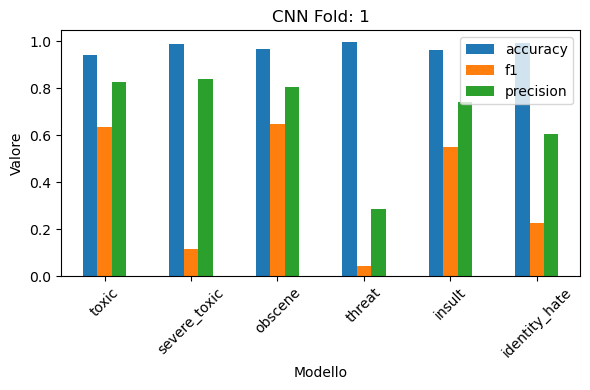

Media accuratezza: 0.9758264139119537


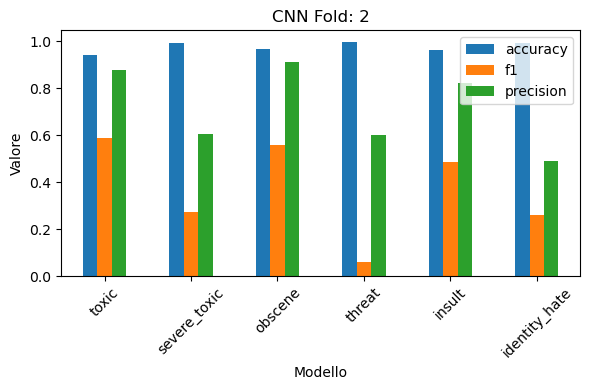

Media accuratezza: 0.9750214117106389


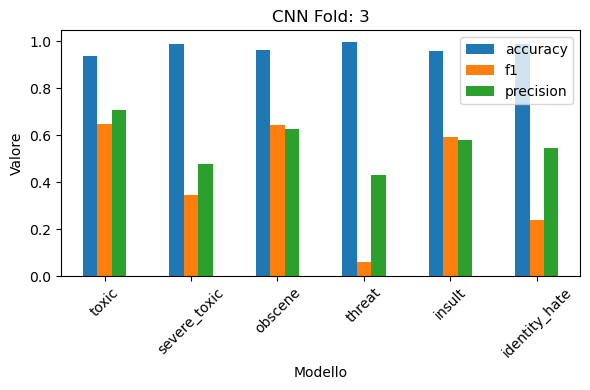

Media accuratezza: 0.9722796682751561


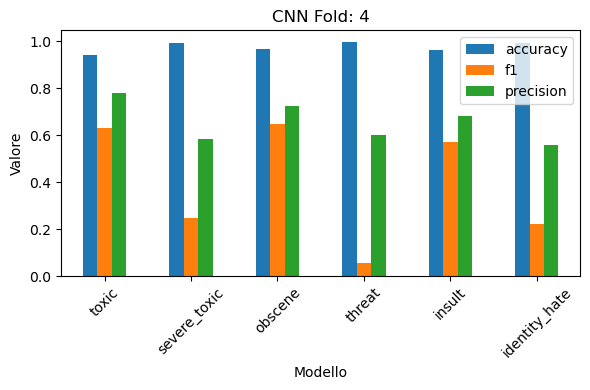

Media accuratezza: 0.9752668630277203


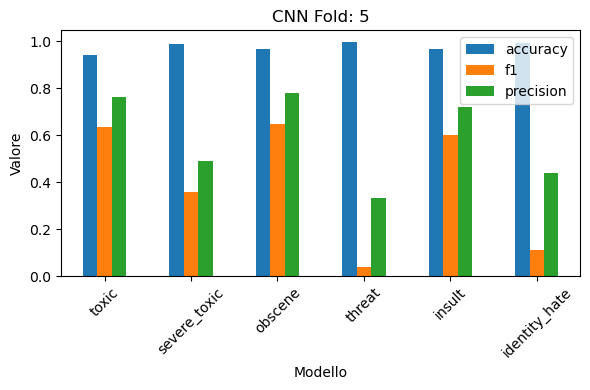

Media accuratezza: 0.9754339788180735


In [89]:
i=0
all_cnn_accuracy = []
for fold in cnn_metrics:
    i+=1
    vis_metrics(fold,"CNN Fold: "+str(i))
    accuratezze = np.array([fold['identity_hate']['accuracy'],fold['insult']['accuracy'],fold['threat']['accuracy'],fold['obscene']['accuracy'],fold['severe_toxic']['accuracy'],fold['toxic']['accuracy']])
    media_accuratezza = np.mean(accuratezze)
    all_cnn_accuracy.append(media_accuratezza)
    print(f"Media accuratezza: {media_accuratezza}")

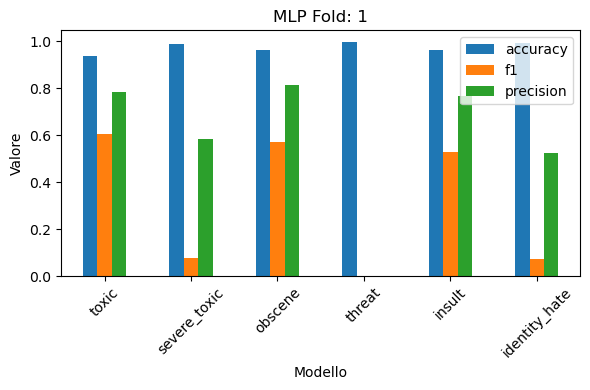

Media accuratezza: 0.9742284192386025


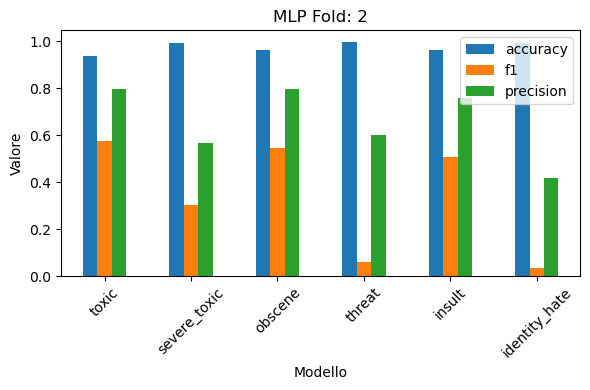

Media accuratezza: 0.9737053748616072


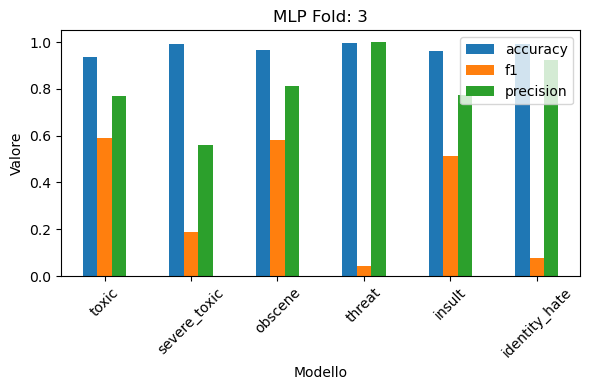

Media accuratezza: 0.9737210419669529


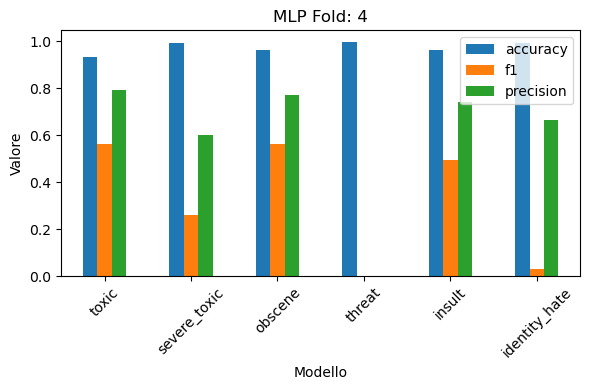

Media accuratezza: 0.9737419314407468


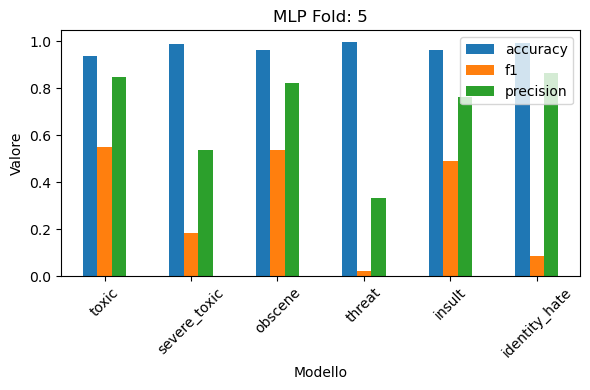

Media accuratezza: 0.9735852603872908


In [90]:
i=0
all_mlp_accuracy = []
for fold in mlp_metrics:
    i=i+1
    vis_metrics(fold,"MLP Fold: "+str(i))
    accuratezze = np.array([fold['identity_hate']['accuracy'],fold['insult']['accuracy'],fold['threat']['accuracy'],fold['obscene']['accuracy'],fold['severe_toxic']['accuracy'],fold['toxic']['accuracy']])
    media_accuratezza = np.mean(accuratezze)
    all_mlp_accuracy.append(media_accuratezza)
    print(f"Media accuratezza: {media_accuratezza}")

C:\Users\cavas\AppData\Local\Temp\ipykernel_11576\1484887782.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels)


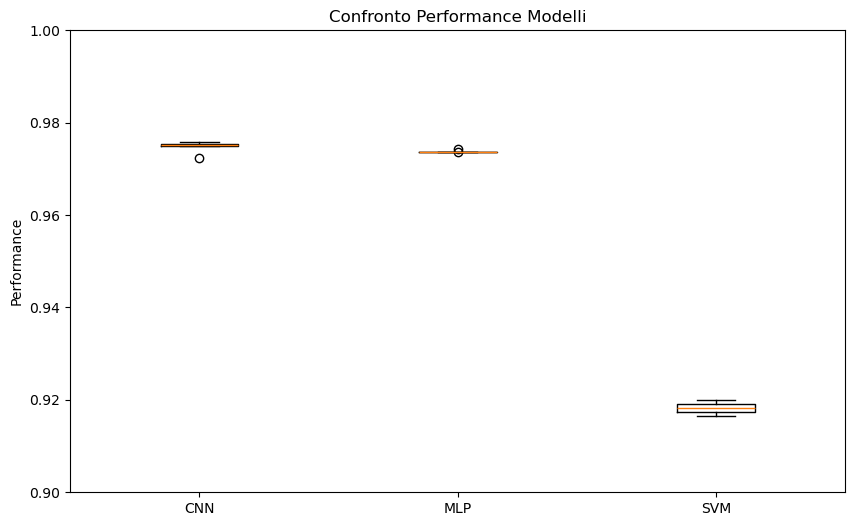

In [101]:
def crea_box_plot_multipli(modelli):

    # Prepara i dati per il box plot
    labels = list(modelli.keys())
    values = list(modelli.values())

    # Crea il box plot
    plt.figure(figsize=(10, 6))  # Aggiustiamo le dimensioni per più modelli
    plt.boxplot(values, labels=labels)
    plt.ylim(0.9, 1.0) 

    # Aggiungi titolo ed etichette
    plt.title('Confronto Performance Modelli')
    plt.ylabel('Performance')

    # Mostra il grafico
    plt.show()

models = {'CNN': all_cnn_accuracy,
          'MLP': all_mlp_accuracy,
          'SVM': [0.92002, 0.9165]} # i have calculated them before

crea_box_plot_multipli(models)